Hyperparameters to look at for Random Forest: 
min samples leaf, followed by max features per split and number of estimators

For XGBoost
For learning rate, higher values of 0.2 and above tended to perform better.
For subsample, the density was increased above 0.8.
For min child weight, there is increased density at lower values. A setting of 0 means no minimum weight is required on the sum of the instance weight in a child, therefore no regularization. This means the algorithm can be much slower, and thus setting this parameter to 1 (which is the default value) represents a good trade off between performance and training time.

  - n_estimators: represents the number of decision trees in the "forest". A higher number will usually give a better response, but will require a lot more processing power. 
  - min sample leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regressi
  - max_features:  the maximum number of features to be considered for a split in a tree. Usually the ideal number lies somewhere around the square root of the number of features present, so this function will accept either a number, or a string value that defines the calculation that should be made for a number.


In [8]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import cohen_kappa_score
import imblearn
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import make_pipeline
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold


In [3]:
red_wines = pd.read_csv("winequality-red.csv", sep = ";")
white_wines = pd.read_csv("winequality-white.csv", sep =";")

# formatting
red_wines.columns= red_wines.columns.str.replace(' ','_')
white_wines.columns = white_wines.columns.str.replace(' ','_')

#Quality categories
red_wines ['quality_label'] = red_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

red_wines['quality_label'] = pd.Categorical(red_wines['quality_label'],
categories=['low', 'medium', 'high'])

white_wines ['quality_label'] = white_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

white_wines["quality_label"] = pd.Categorical(white_wines["quality_label"], categories = ["low","medium","high"])

# Type of wine categories
red_wines ["type"] = 'Red Wine'
red_wines['type'] = pd.Categorical(red_wines['type'],
categories=["Red Wine","White Wine"])

white_wines ["type"] = 'White Wine'
white_wines['type'] = pd.Categorical(white_wines['type'],
categories=["Red Wine","White Wine"])


In [4]:
# filtered outliers
white_wines_clean= white_wines.drop("quality", axis=1)
numeric_columns_white = white_wines_clean.select_dtypes(include=['float64', 'int64'])

white_wine_filtered= white_wines.copy()
for column in numeric_columns_white.columns:
        q1 = np.quantile(numeric_columns_white[column], 0.25)
        q3 = np.quantile(numeric_columns_white[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        white_wine_filtered = white_wine_filtered[(white_wine_filtered[column] >= lower) & (white_wine_filtered[column] <= upper)]
print("white wine shape; ", white_wines.shape, "\nfiltered white wine shape: ", white_wine_filtered.shape)

red_wines_clean= red_wines.drop("quality", axis=1)
numeric_columns_red = red_wines_clean.select_dtypes(include=['float64', 'int64'])

red_wine_filtered= red_wines.copy()
for column in numeric_columns_red.columns: 
        q1 = np.quantile(numeric_columns_red[column], 0.25)
        q3 = np.quantile(numeric_columns_red[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        red_wine_filtered = red_wine_filtered[(red_wine_filtered[column] >= lower) & (red_wine_filtered[column] <= upper)]
print("red wine shape; ", red_wines.shape, "\nfiltered red wine shape: ", red_wine_filtered.shape)

white wine shape;  (4898, 14) 
filtered white wine shape:  (4015, 14)
red wine shape;  (1599, 14) 
filtered red wine shape:  (1194, 14)


In [5]:
# merge datasets
white_and_red_filtered = pd.merge(red_wine_filtered, white_wine_filtered, how = "outer")

# Encoding
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red_filtered['quality_label_encoded'] = enc.fit_transform(white_and_red_filtered[['quality_label']])

#Feauture / Target split
X=white_and_red_filtered.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y= white_and_red_filtered["quality_label_encoded"]

# #Smote
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## standarization
norm = MinMaxScaler().fit(X)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)

# define model
RF_clf = RandomForestClassifier(random_state=42)
# fit model

RF_clf.fit(X_train_norm, y_train)

RF_preds = RF_clf.predict(X_test_norm)

RF_acc = accuracy_score(y_test, RF_preds)

RF_acc


0.8157389635316699

In [5]:
n_estimators = np.arange(100,220,20)
min_samples_leaf = np.arange(2, 12, 2)
max_features = ["sqrt", "log2", None]

param_grid = {
  'n_estimators': n_estimators,
  'min_samples_leaf': min_samples_leaf,
  'max_features': max_features,
}

param_grid

{'n_estimators': array([100, 120, 140, 160, 180, 200]),
 'min_samples_leaf': array([ 2,  4,  6,  8, 10]),
 'max_features': ['sqrt', 'log2', None]}

# Randomized Search CV

In [6]:
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
RS_grid = RandomizedSearchCV(estimator=RF_clf, param_distributions=param_grid, n_iter=10)
RS_grid

RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([100, 120, 140, 160, 180, 200])})

In [7]:
RS_grid.fit(X_train_norm, y_train)


RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([100, 120, 140, 160, 180, 200])})

In [8]:
print(
  'best score: ', RS_grid.best_score_,
  '\nparams: ', RS_grid.best_params_
)

best score:  0.786176053155075 
params:  {'n_estimators': np.int64(160), 'min_samples_leaf': np.int64(4), 'max_features': 'sqrt'}


# Random forest with stratified kfold

In [6]:
# with filtered rows

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced")

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle= True)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred = rf.predict(x_test_fold) 
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(f"{kappa:.4f}")


# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print("\nList of possible Cohen-Kappa score:", lst_kappa)
print("\nList of possible balanced accuracy score:", lst_balanced_accuracy_score)

List of possible accuracy: [0.8406909788867563, 0.8080614203454894, 0.800383877159309, 0.817658349328215, 0.8349328214971209, 0.8349328214971209, 0.8157389635316699, 0.8061420345489443, 0.8291746641074856, 0.8211538461538461]

Maximum Accuracy That can be obtained from this model is: 84.06909788867563 %

Minimum Accuracy: 80.03838771593091 %

Overall Accuracy: 82.08869777055958 %

Standard Deviation is: 0.013722400083705686

List of possible Cohen-Kappa score: ['0.6603', '0.5815', '0.5615', '0.5963', '0.6328', '0.6405', '0.6013', '0.5717', '0.6305', '0.6090']

List of possible balanced accuracy score: ['0.7371', '0.6119', '0.6404', '0.5953', '0.6621', '0.6512', '0.6332', '0.6233', '0.7037', '0.6946']


In [21]:
from sklearn.model_selection import RepeatedStratifiedKFold
_estimators = np.arange(100,310,20)
min_samples_leaf = np.arange(2, 10, 2)
max_features = ["sqrt", "log2", None]
# skf = StratifiedKFold(n_splits=10, random_state=1, shuffle= True)
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

param_grid = {
  'n_estimators': n_estimators,
  'min_samples_leaf': min_samples_leaf,
  'max_features': max_features,
}

RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
rs_grid2 = RandomizedSearchCV(
    estimator=RF_clf, 
    param_distributions=param_grid, 
    n_iter=10,
    scoring= "accuracy",
    cv= skf,
    random_state=42,
    n_jobs=-1,
    refit= True
    )

rs_grid2.fit(X_train_norm, y_train)

print(
  'best score: ', rs_grid2.best_score_,
  '\nparams: ', rs_grid2.best_params_
)

best score:  0.8043357621595032 
params:  {'n_estimators': np.int64(180), 'min_samples_leaf': np.int64(2), 'max_features': 'sqrt'}


In [15]:
rs_grid2.cv_results_

grid_results = pd.concat([
  pd.DataFrame(rs_grid2.cv_results_["params"]),
  pd.DataFrame(rs_grid2.cv_results_["mean_test_score"], columns=["Accuracy"])
], axis=1)

grid_results.sort_values(by="Accuracy")

,n_estimators,min_samples_leaf,max_features,Accuracy
5,140,10,sqrt,0.754991
2,120,10,log2,0.756671
1,180,8,sqrt,0.765547
9,140,6,log2,0.772985
3,180,4,None,0.784025
0,180,4,log2,0.786661
8,180,4,sqrt,0.786661
6,160,4,log2,0.787143
7,200,2,None,0.799861
4,100,2,sqrt,0.804421


# gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
_estimators = np.arange(100,200,10)
min_samples_leaf = np.arange(2, 8, 2)
max_features = ["sqrt", "log2", None]
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle= True)
# skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

param_grid = {
  'n_estimators': n_estimators,
  'min_samples_leaf': min_samples_leaf,
  'max_features': max_features,
}

RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
gs_grid = GridSearchCV(
    estimator=RF_clf, 
    param_grid=param_grid, 
    scoring= "accuracy",
    cv= skf,
    n_jobs=-1,
    refit= True
    )

gs_grid.fit(X_train_norm, y_train)

print(
  'best score: ', gs_grid.best_score_,
  '\nparams: ', gs_grid.best_params_
)

best score:  0.8051397343663531 
params:  {'max_features': 'sqrt', 'min_samples_leaf': np.int64(2), 'n_estimators': np.int64(200)}


# Applying the hyperparameters

In [23]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced", n_estimators=100, min_samples_leaf=2, max_features="sqrt")

# Create StratifiedKFold object.
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold_1 = y[train_index], y[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred_1 = rf.predict(x_test_fold) 
    kappa = cohen_kappa_score(rf_pred_1, y_test_fold_1)
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold_1))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold_1, rf_pred_1)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(round(kappa, 4))


# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')

List of possible accuracy: [0.800383877159309, 0.8310940499040307, 0.8349328214971209, 0.800383877159309, 0.8042226487523992, 0.8119001919385797, 0.8023032629558541, 0.8310940499040307, 0.8157389635316699, 0.8288461538461539, 0.8099808061420346, 0.8330134357005758, 0.8080614203454894, 0.8214971209213052, 0.8080614203454894, 0.8138195777351248, 0.8042226487523992, 0.8061420345489443, 0.8099808061420346, 0.8307692307692308, 0.8349328214971209, 0.8099808061420346, 0.8080614203454894, 0.8023032629558541, 0.7677543186180422, 0.8349328214971209, 0.8138195777351248, 0.8656429942418427, 0.800383877159309, 0.8038461538461539]

Maximum Accuracy That can be obtained from this model is: 86.56429942418427 %

Minimum Accuracy: 76.77543186180422 %

Overall Accuracy: 81.4936881736306 %

Standard Deviation is: 0.017562940917110054

Maximum Cohen-Kappa score that can be obtained from this model is: 71.53 %

Maximum Balanced Accuracy That can be obtained from this model is: 0.75770.75770.75770.75770.7577

In [10]:
# Classification report
print("Classification Report:")
print(classification_report(y_test_fold_1, rf_pred_1))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73       175
         1.0       0.82      0.89      0.85       329
         2.0       1.00      0.31      0.48        16

    accuracy                           0.81       520
   macro avg       0.86      0.63      0.69       520
weighted avg       0.81      0.81      0.80       520



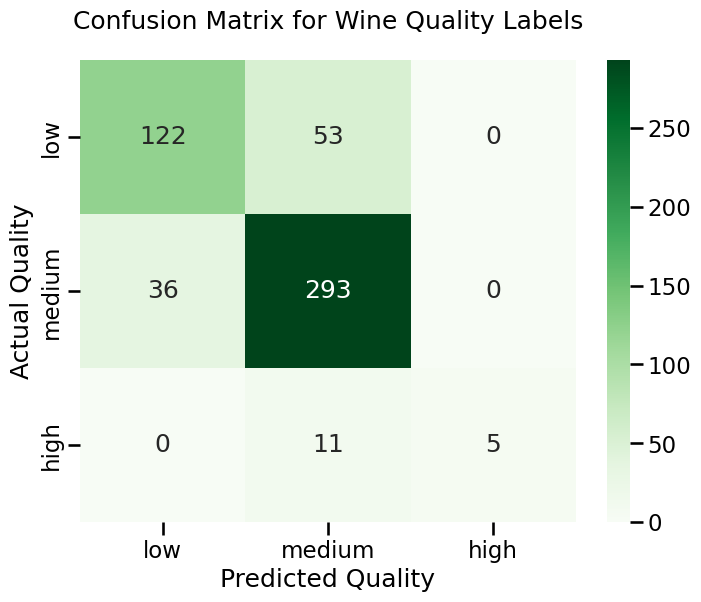

In [22]:
cm = confusion_matrix(y_test_fold_1, rf_pred_1)
plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix for Wine Quality Labels', y=1.05)
plt.show()